## Now I try to play with the radial gradient of Balmer decrement

In [1]:
from    astropy.table       import Table
import  numpy               as     np
from    astropy.io          import fits
from    astropy.cosmology   import Planck15
import  astropy.units       as     u
import  matplotlib.pyplot   as     plt
import  matplotlib.colors   as     colors  
import matplotlib
matplotlib.use('Agg')
from    functools           import reduce
from    tqdm                import tqdm
import  os
import  gc                                         
import warnings

warnings.filterwarnings("ignore", message="marker is redundantly defined")

#this is just a handy little function to return the desired file path
#give one entry in the object list, return the desired file path
def file_path(obj,prefix,filetype='fits'):
    if   filetype == 'fits':
        return f"data\\{obj['field']}\\{obj['field']}_{str(obj['id']).zfill(5)}.{prefix}.{filetype}"
    elif filetype == 'png':
        return f"png\\{obj['field']}\\{obj['field']}_{str(obj['id']).zfill(5)}.{prefix}.{filetype}"

In [2]:
#calculate distance of each pixel to center:
def image_to_center_distance(obj):
    y,x = np.indices((50,50))
    center = (np.array((50,50)) - 1) / 2
    distance = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    pixel_length = (0.04*u.arcsec).to(u.rad) * Planck15.luminosity_distance(obj['redshift']).to(u.kpc)
    return distance*pixel_length


def extract_radial_profile(hdu):
    mask = hdu[2].data == obj['id']
    distances_obj  = image_to_center_distance(obj)[mask].value
    sort = np.argsort(distances_obj)
    distances_obj = distances_obj[sort]
    balmer_obj     = hdu[13].data[mask][sort]
    balmer_obj_err = hdu[14].data[mask][sort]
    new_table = fits.BinTableHDU(table,name='RADIAL_DECREM')
    dtype = [('DISTANCE [kpc]', 'f4'), ('BALMER_DECREM', 'f4'), ('BALMER_DECREM_ERR', 'f4')]
    return np.array(list(zip(distances_obj, balmer_obj, balmer_obj_err)), dtype=dtype)


In [10]:

obj_lis = Table.read('spectra-fitting_selected_psfmatched.fits')
for obj in tqdm(obj_lis):
    path = file_path(obj=obj,prefix='extracted')
    with fits.open(path) as hdu:

        update_radial_profile = False
        if update_radial_profile: 
            new_table = extract_radial_profile(hdu)
            if len(hdu)>14:
                hdu[-1] = new_table
                hdu.flush()
            else:
                hdu.append(new_table)

                hdu.flush

  0%|          | 0/1917 [00:00<?, ?it/s]

100%|██████████| 1917/1917 [00:01<00:00, 1064.28it/s]


### plot halpha, convolved hbeta and radial balmer decrement map (pixel-to-pixel)


  0%|          | 0/1 [00:00<?, ?it/s]

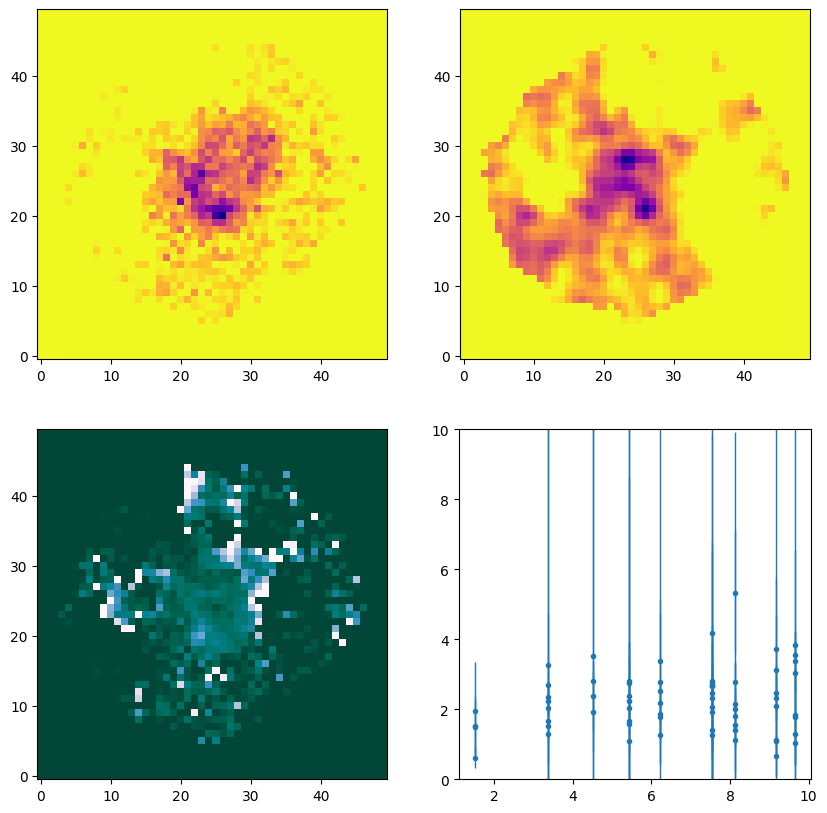

100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


In [20]:
%matplotlib inline
i= 136
obj_lis = Table.read('spectra-fitting_selected_psfmatched.fits')
for obj in tqdm(obj_lis[0:1]):
    path = file_path(obj=obj,prefix='extracted')
    with fits.open(path) as hdu:

        seg = hdu[2].data == obj['id']

        ax = plt.figure(figsize=(10,10));i=1
        for index in [4,11]:
            ax.add_subplot(int(f'22{i}'))
            plt.imshow(np.where(seg,hdu[index].data,0),
                        norm=colors.Normalize(vmin=0),
                        origin='lower',
                        cmap = 'plasma_r')
            i+=1

        ax.add_subplot(223)
        plt.imshow(np.where(seg,hdu[13].data,0),
                    norm=colors.Normalize(vmin=0,vmax=15),
                    origin='lower',
                    cmap = 'PuBuGn_r')
        
        balmer_obj     = hdu[13].data[seg]   
        balmer_obj_err = hdu[14].data[seg]
        distances_obj  = image_to_center_distance(obj)[seg].value
        mask = reduce(np.logical_and,
                [distances_obj <10 , 
                balmer_obj_err.flatten()<100, 
                #balmer_obj<70000000,
                hdu[5].data[seg]  > 0,
                hdu[11].data[seg] > 0        ])
        
        ax.add_subplot(224)
        plt.errorbar(distances_obj[mask],balmer_obj.flatten()[mask]
                    ,yerr=balmer_obj_err.flatten()[mask],
                    linewidth=0,marker='.',elinewidth=1)
        plt.ylim(0,10)
        plt.show()


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_fits(obj):
    try:
        path = file_path(obj=obj,prefix='extracted')
        with fits.open(path) as hdu:

            seg = hdu[2].data == obj['id']

            ax = plt.figure(figsize=(10,10));i=1
            for index in [3,10,4,11]:
                ax.add_subplot(int(f'32{i}'))
                plt.imshow(#np.where(seg,hdu[index].data,0),
                            hdu[index].data,
                            norm=colors.Normalize(vmin=0),
                            origin='lower',
                            cmap = 'plasma_r')
                plt.title(hdu[index].name)
                plt.grid()
                i+=1

            ax.add_subplot(325)
            plt.imshow(np.where(seg,hdu[13].data,0),
                        norm=colors.Normalize(vmin=0,vmax=15),
                        origin='lower',
                        cmap = 'plasma_r')
            plt.grid()
            plt.title('Ha/Hb')
            
            balmer_obj     = hdu[13].data[seg]   
            balmer_obj_err = hdu[14].data[seg]
            distances_obj  = image_to_center_distance(obj)[seg].value
            mask = reduce(np.logical_and,
                    [distances_obj <10 , 
                    balmer_obj_err.flatten()<100, 
                    #balmer_obj<70000000,
                    hdu[5].data[seg]  > 0,
                    hdu[11].data[seg] > 0])
            
            ax.add_subplot(326)
            plt.errorbar(distances_obj[mask],balmer_obj.flatten()[mask]
                        ,yerr=balmer_obj_err.flatten()[mask],
                        linewidth=0,marker='.',elinewidth=1)
            plt.ylim(0,10)
            plt.xlabel('radius[kpc]')
            plt.title('radial profile balmer decrement, pixel to pixel')
            plt.grid()
            plt.savefig(f"pixel_to_pixel_balmer_decrem/{obj['field']}-{obj['id']}.png")
            plt.close()
            return f"{obj['field']}-{obj['id']}saved"
        
    except Exception as e:
        return f"! {obj['field']}-{obj['id']} failed, error{e}"

def cat_process(obj_lis,max_threads=12):
        results = []
        with ThreadPoolExecutor(max_threads) as executor:
            futures = {executor.submit(process_fits,obj):obj for obj in obj_lis}
            for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                results.append(future.result())
        return results

if __name__ == '__main__':
    obj_lis = Table.read('spectra-fitting_selected_psfmatched.fits')
    results = cat_process(obj_lis,max_threads=10)
    number = 0
    for result in results:
        if 'error' in result:
            number +=1
    print('total number of obj processed:',len(results))
    print('number of failed obj',number)

Processing: 100%|██████████| 1917/1917 [10:33<00:00,  3.03it/s]

total number of obj processed: 1917
number of failed objescts 7
